#Install libraries

In [1]:
# Uncomment to install phasorpy and ptufile
print("Installing necessary libraries...")
#!pip install phasorpy > /dev/null 2>&1
#!pip install ptufile > /dev/null 2>&1
#!pip install PyQt5 > /dev/null 2>&1
#!pip install napari[all] > /dev/null 2>&1
#!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
#!pip install cmcrameri
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load libraries

In [3]:
import matplotlib.pyplot as plt
#libraries for the Scale bar
import matplotlib.patches as patches
import matplotlib.colors as colors

#libraries for the phasor plot and phasor analysis
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu, lifetime_from_lif, phasor_from_lif
from phasorpy.plot import plot_signal_image, plot_phasor_image, PhasorPlot
from phasorpy.phasor import phasor_from_signal, phasor_threshold, phasor_filter_median
from phasorpy.lifetime import lifetime_to_signal, phasor_calibrate, phasor_from_lifetime, phasor_to_apparent_lifetime
from phasorpy.cursor import mask_from_circular_cursor, mask_from_elliptic_cursor, mask_from_polar_cursor, pseudo_color
from phasorpy.color import CATEGORICAL

#library for MSSR
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

#additional libraries
import cmcrameri.cm as cmc
import numpy as np

#Tif file
import tifffile


This exception is what's causing cl equals None: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR


/usr/local/lib/python3.12/dist-packages/liquid_engine/__opencl__.py:125: UserWarning: tap... tap... tap... COMPUTER SAYS NO (OpenCL)!
  warnings.warn("tap... tap... tap... COMPUTER SAYS NO (OpenCL)!")
/usr/local/lib/python3.12/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Optional dependecy Dask_image is not installed. Implementations using it will be ignored.


## Parameters for figures and additional functions

In [4]:
# Figure formatting
fontsize = 24
labelsize = 26
ticksize = 25
lw = 4

## ### Function to plot histograms

def plot_histograms(
    *data,
    title=None,
    xlabel=None,
    ylabel=None,
    labels=None,
    show=True,
    title_fontsize = 18,
    label_fontsize=16,
    tick_labelsize=14,
    legend_fontsize=14,
    density=False,  # Added density parameter
    **kwargs,
) -> None:
    """Plot histograms of flattened data arrays.

    Parameters
    ----------
    data: array_like
        Data arrays to be plotted as histograms.
    title : str, optional
        Figure title.
    xlabel : str, optional
        Label for x-axis.
    ylabel : str, optional
        Label for y-axis.
    labels: sequence of str, optional
        Labels for each data array.
    show : bool, optional, default: True
        Display figure.
    density : bool, optional, default: False
        Normalize the histogram such that the integral over the range is 1.
    **kwargs
        Additional arguments passed to :func:`matplotlib.pyplot.hist`.

    """
    ax = plt.subplots()[1]
    if kwargs.get('alpha') is None:
        ax.hist(
            [np.asarray(d).flatten() for d in data], label=labels, density=density, **kwargs # Added density
        )
    else:
        for d, label in zip(
            data, [None] * len(data) if labels is None else labels
        ):
            ax.hist(np.asarray(d).flatten(), label=label, density=density, **kwargs) # Added density
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize = label_fontsize)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize = label_fontsize)
    if labels is not None:
        ax.legend(fontsize=legend_fontsize)
    #Tick size
    ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)

    plt.tight_layout()
    if show:
        plt.show()

## Load data

In [5]:
# Signal from PTU file

img_data = '/content/drive/MyDrive/2025/GattaQuant/Series009_seq1.ptu'
ref_data = '/content/drive/MyDrive/2025/MSSR-FLIM/Data/ICFO/ATTO488 (reference)/80MHz/ATTO488_200nM_LaserPower10_10LineRep_10FrameAccum_80MHz[1].ptu'

# Signal from LIF file

#img_data = '/content/drive/MyDrive/2025/MSSR-FLIM/Data/GATTA_IVAN/wetransfer_datos-flim-icfo-ivancoto_2025-06-06_0737/20250529/Image3_50accum_0p2laserpower_100Hz.lif'


#img_data = '/content/drive/MyDrive/2025/Articulos/MSSR-FLIM/Data/GATTA_IVAN/wetransfer_datos-flim-icfo-ivancoto_2025-06-06_0737/20250529/Image1_50accum_0p2laserpower_100Hz_80nm_channel1_524to651nm.sptw/Series009_seq1.ptu'  ## Adan's computer
#ref_data = '/content/drive/MyDrive/2025/Articulos/MSSR-FLIM/Data/ICFO/ATTO488 (reference)/80MHz/ATTO488_200nM_LaserPower10_10LineRep_10FrameAccum_80MHz[1].ptu'  ## Adan's computer

#signal = signal_from_ptu(img_data)
#signal =  np.mean(signal, axis=0)  # Shape: (512, 512, 132)

#ref_signal = signal_from_ptu(ref_data)
#ref_signal =  np.mean(ref_signal, axis=0)  # Shape: (512, 512, 132)

signal = signal_from_ptu(img_data,  frame = 0) ## uncoment to analyze a single frame
ref_signal = signal_from_ptu(ref_data, frame = 0) ## uncoment to analyze a single frame
frequency = ref_signal.attrs['frequency']


#####  Uncoment to average four replicates
mean_signal = np.mean(signal, axis=0)  # Shape: (512, 512, 132)
print(signal.shape)
print(ref_signal.shape)
#signal = np.squeeze(signal, axis=0)

#### Uncoment to remove IRF
#signal = signal[:,:,1:74]
#print(mean_signal.shape)

(512, 512, 132)
(512, 512, 132)


In [6]:
signal = signal_from_ptu(img_data)
signal =  np.mean(signal, axis=0)  # Shape: (512, 512, 132)


In [7]:
ref_signal = signal_from_ptu(ref_data)
ref_signal =  np.mean(ref_signal, axis=0)  # Shape: (512, 512, 132)

## Explore the data

In [75]:
#print("Signal Values:\n", signal.values)
print("\nSignal Data Type:", signal.dtype)
print("\nSignal Shape:", signal.shape)
print("\nSignal Dimensions:", signal.dims)
#print("\nSignal 'H' Coordinates Data:\n", signal.coords['H'].data)
#print("\nSignal Frequency Attribute:", signal.attrs['frequency'])


#print("Signal Values:\n", signal.values)
print("\nRef Signal Data Type:", ref_signal.dtype)
print("\nRef Signal Shape:", ref_signal.shape)
print("\nRef Signal Dimensions:", ref_signal.dims)
#print("\nSignal 'H' Coordinates Data:\n", ref_signal.coords['H'].data)
#print("\nRef Signal Frequency Attribute:", ref_signal.attrs['frequency'])


Signal Data Type: float64

Signal Shape: (512, 512, 132)

Signal Dimensions: ('Y', 'X', 'H')

Ref Signal Data Type: float64

Ref Signal Shape: (512, 512, 132)

Ref Signal Dimensions: ('Y', 'X', 'H')


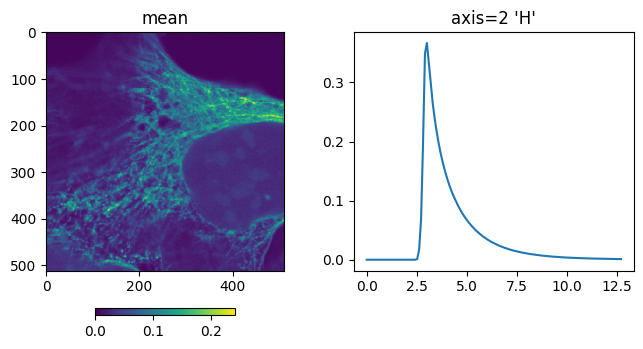

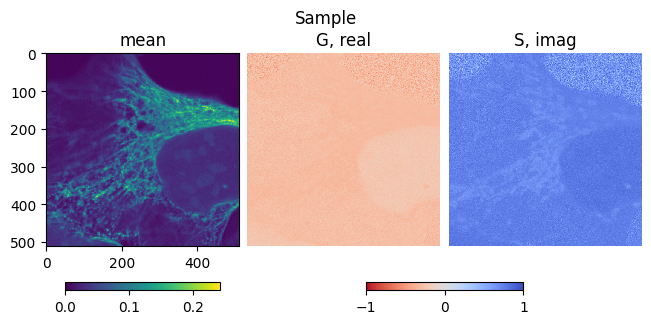

(512, 512)
(512, 512)
(512, 512)


In [76]:
plot_signal_image(signal, axis='H')
mean, real, imag = phasor_from_signal(signal, axis='H')
plot_phasor_image(mean, real, imag, title='Sample')
print(mean.shape)
print(real.shape)
print(imag.shape)

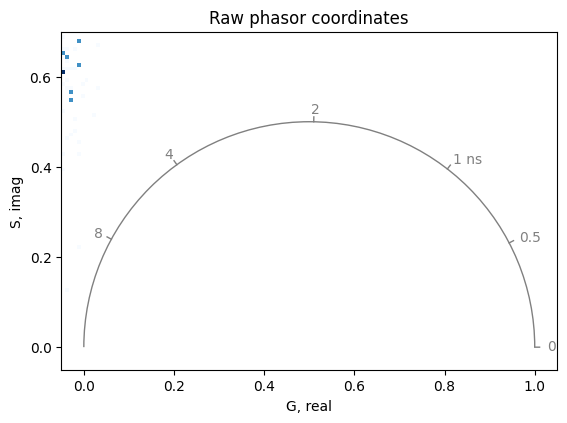

In [77]:
phasorplot = PhasorPlot(
    frequency=frequency, title='Raw phasor coordinates'
)
phasorplot.hist2d(real, imag)
phasorplot.show()

## Load a TD-FLIM reference signal,  a homogeneous solution of Atto 488 with a lifetime of 4.1 ns.

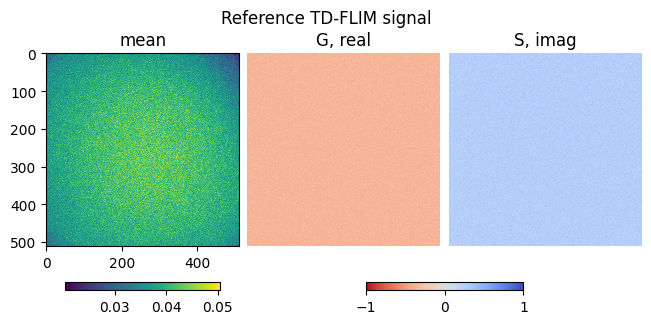

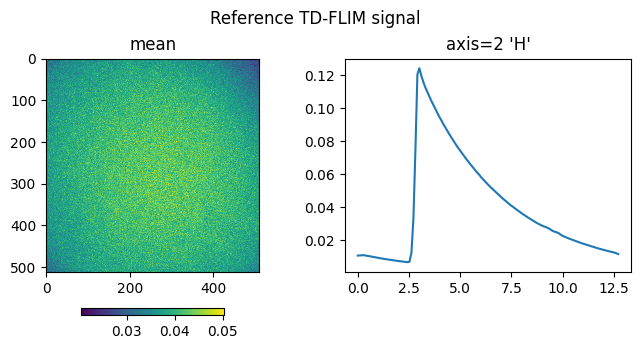

In [78]:
reference_lifetime = 4.1

img_reference_signal = ref_signal
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

plot_phasor_image(
    img_reference_mean, img_reference_real, img_reference_imag, title='Reference TD-FLIM signal'
)

plot_signal_image(img_reference_signal, title='Reference TD-FLIM signal')

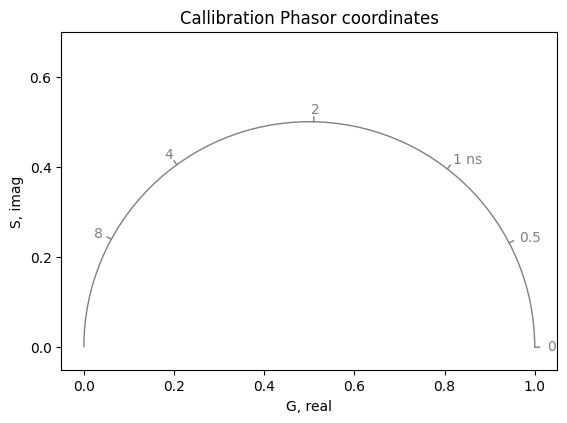

In [79]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Callibration Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag, color = 'b')
  plot.show()

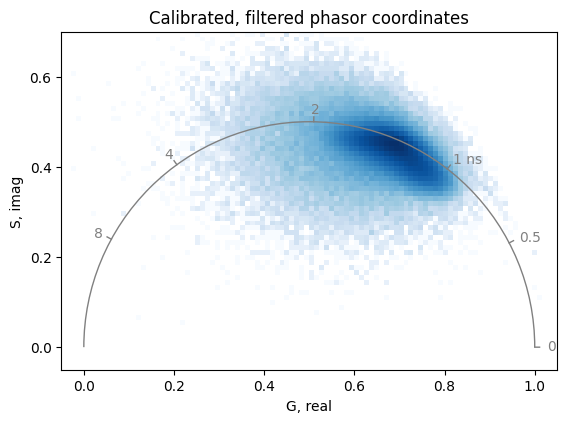

In [80]:

# Calibrate phasor coordinates using reference
real_cal, imag_cal = phasor_calibrate(real, imag, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_cal, imag_cal, bins = 100)


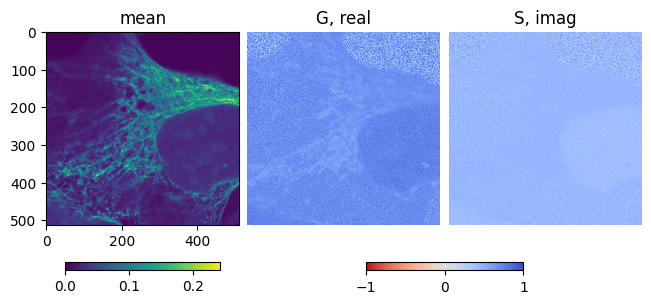

(512, 512)
(512, 512)
(512, 512)


In [81]:
plot_phasor_image(mean, real_cal, imag_cal)
print(mean.shape)
print(real_cal.shape)
print(imag_cal.shape)

## Filter and threshold

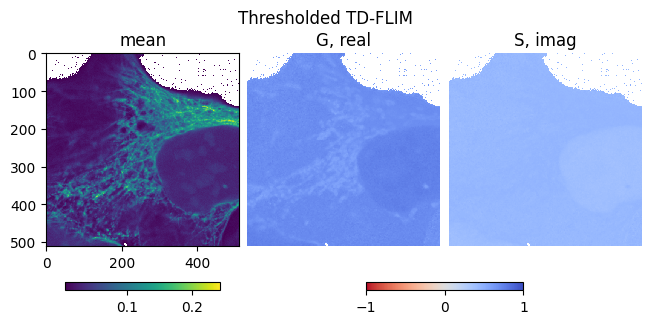

(512, 512)
(512, 512)
(512, 512)


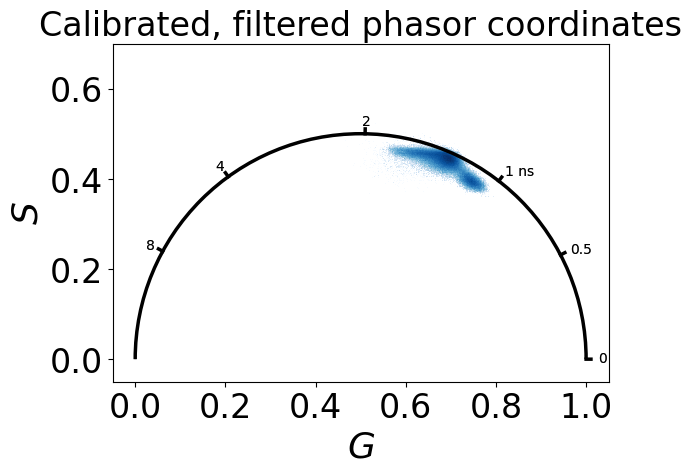

In [94]:
mean_mf, real_mf, imag_mf = phasor_filter_median(mean, real_cal, imag_cal, size=3, repeat=2)

mean_th, real_th, imag_th = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=0.0053)
plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency)
phasorplot.hist2d(real_th, imag_th, bins = 500)
phasorplot.semicircle(frequency, linewidth= 2.5, color ='k')

#Formatting
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Calibrated, filtered phasor coordinates', fontsize = fontsize)

print(mean_th.shape)
print(real_th.shape)
print(imag_th.shape)

## Zoom to phasor plot

Text(0.5, 1.0, 'Calibrated,\nfiltered phasor coordinates')

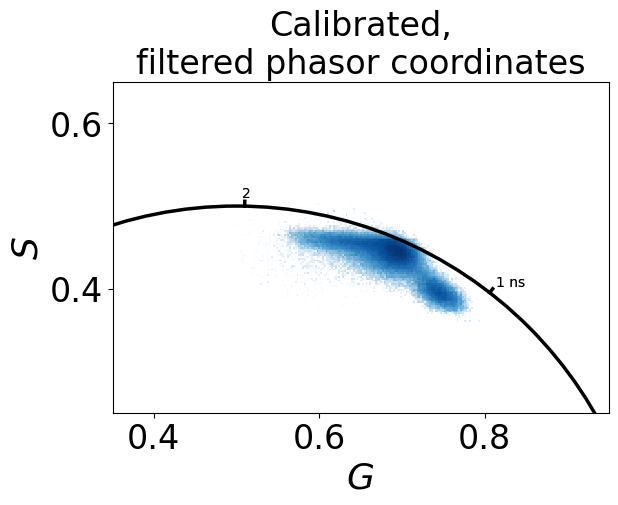

In [95]:
phasorplot = PhasorPlot(frequency=frequency)
phasorplot.hist2d(real_th, imag_th, bins = 500)
phasorplot.semicircle(frequency, linewidth= 2.5, color ='k')

plt.xlim(0.35, 0.95)
plt.ylim(0.25, 0.65)
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Calibrated,\nfiltered phasor coordinates', fontsize = fontsize)

## Cursor analysis

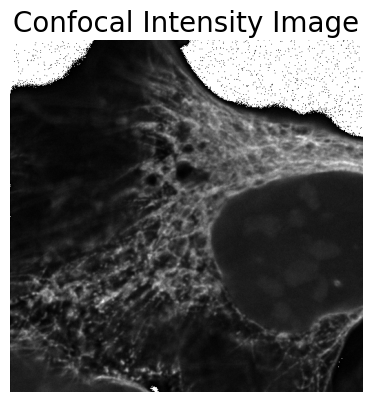

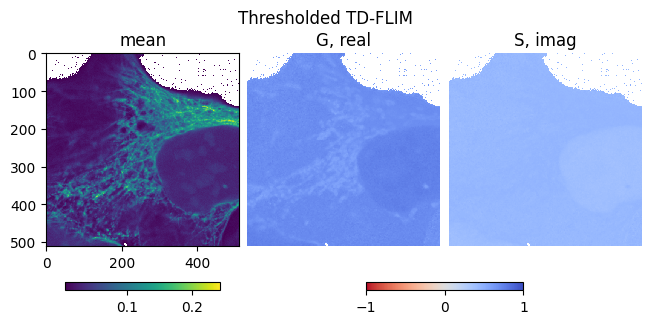

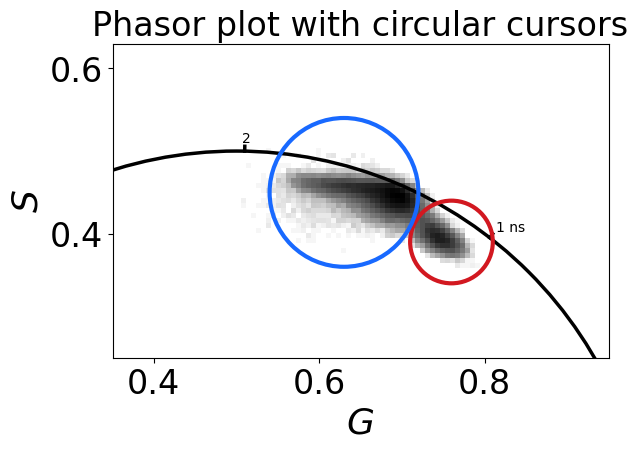

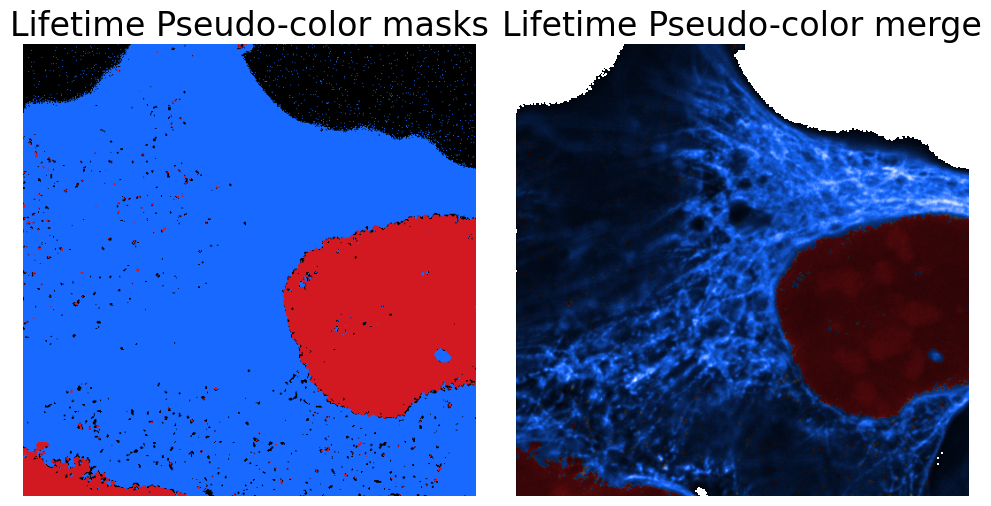

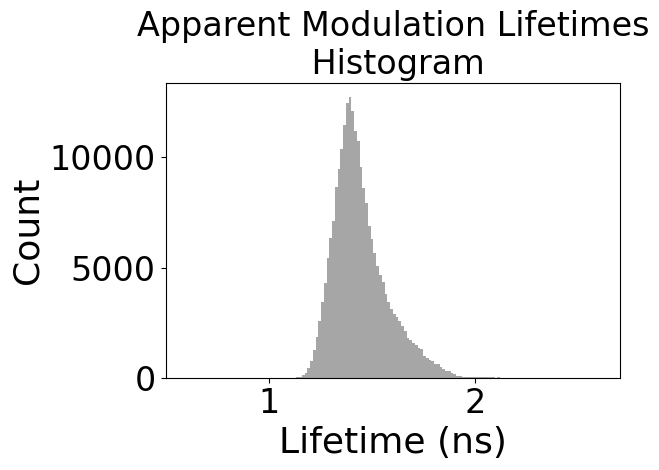

In [96]:
lw = 3
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_th, cmap='gray')
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

# Assigning cursors
cursors_real = [0.76, 0.63]
cursors_imag = [0.39, 0.45]
radius = [0.05, 0.09]

circular_mask = mask_from_circular_cursor(
    real_th, imag_th, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')

plot = PhasorPlot(
    xlim=(0.35, 0.95), ylim=(0.25, 0.63), allquadrants=False, title='Circular cursors')
plot.semicircle(frequency, linewidth= 2.5, color ='k')
plot.hist2d(real_th, imag_th, cmap='Greys', bins = 100)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_th, colors=CATEGORICAL[:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th, imag_th, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

## 3 cursor analysis

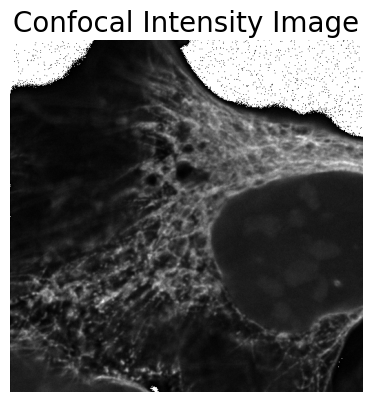

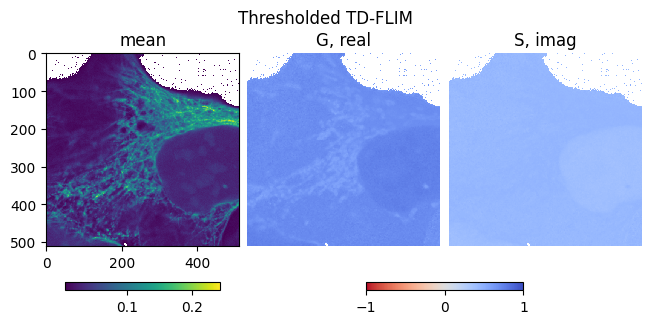

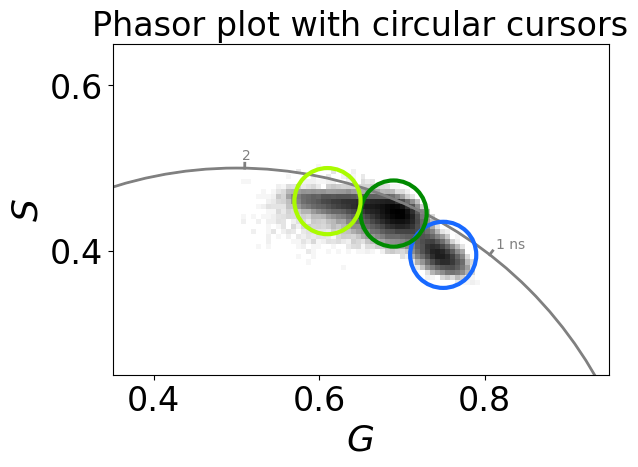

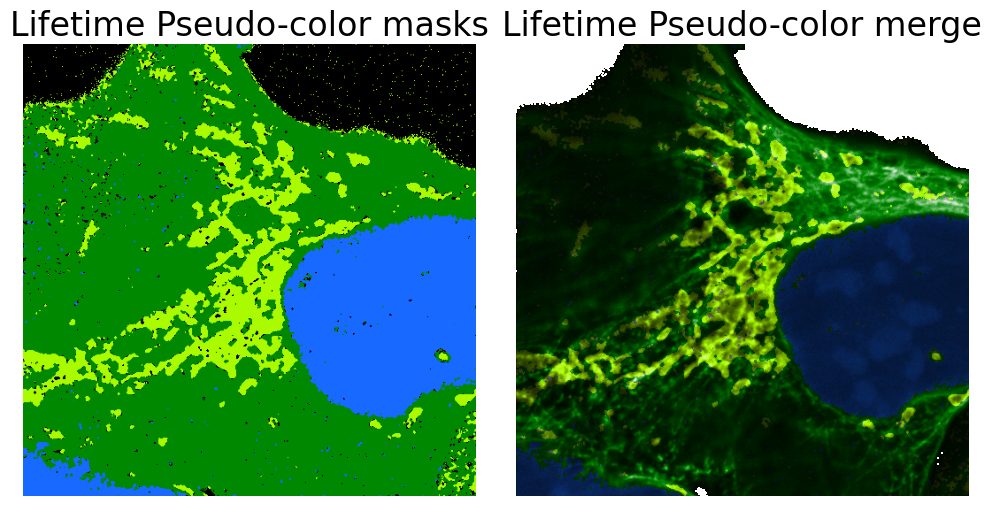

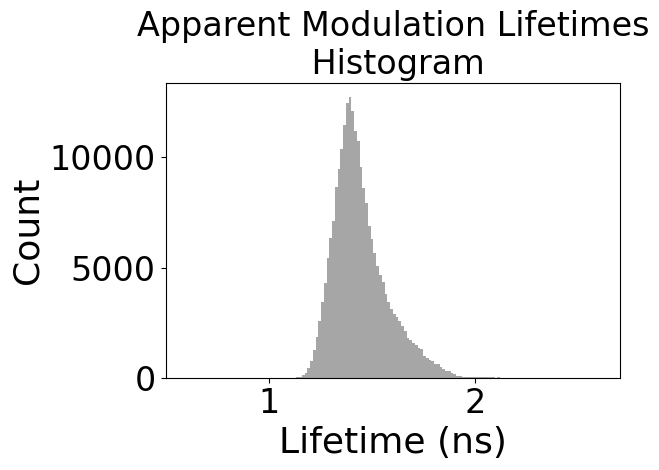

In [103]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_th, cmap='gray')
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

# Assigning cursors
# when using i+1 in CATEGORICAL:
#cursor colors   blue, green, pink, purple, yellow, cyan, ora, brown, darkblue
#components     [DAPI, AF555,    NA,   NA, AF532]
cursors_real =  [0.75, 0.69,   0.01, 0.01,  0.61]
cursors_imag =  [0.395, 0.445, 0.01, 0.01,  0.46]
radius       =  [0.04, 0.04,   0.01, 0.01,  0.04]

circular_mask = mask_from_circular_cursor(
    real_th, imag_th, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')

plot = PhasorPlot(
    xlim=(0.35, 0.95), ylim=(0.25, 0.65), allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=78.02, linewidth= 2)
plot.hist2d(real_th, imag_th, cmap='Greys', bins = 100)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_th, colors=CATEGORICAL[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th, imag_th, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

## Component Analysis

In [104]:
import math

from phasorpy.component import (
    phasor_component_fit,
    phasor_component_fraction,
    phasor_component_graphical,
)

np.random.seed(42)
component_style = {
    'linestyle': '-',
    'linewidth': 3,
    'marker': 'o',
    'color': 'purple',
    'fontsize': 14,
}

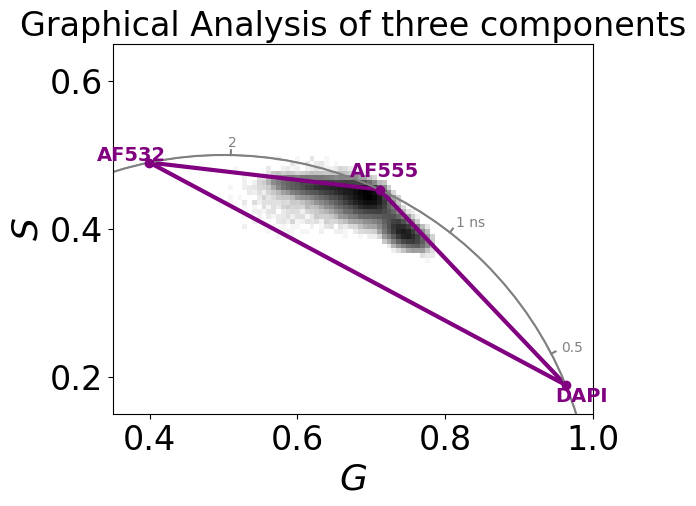

In [105]:
#                     [DAPI, AF555, AF532]
component_lifetimes = [ 0.4,   1.3,   2.5]
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes
)

plot = PhasorPlot(
    xlim=(0.35, 1.0), ylim=(0.15, 0.65), allquadrants=False)
plot.semicircle(frequency=frequency, linewidth= 1.5)

plot.hist2d(real_th, imag_th, cmap='Greys', bins = 100)
#plot.contour(real_th, imag_th, bins=100, cmap='summer_r', norm='log')
plot.components(
    component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style
)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Graphical Analysis of three components', fontsize = fontsize)
plot.show()

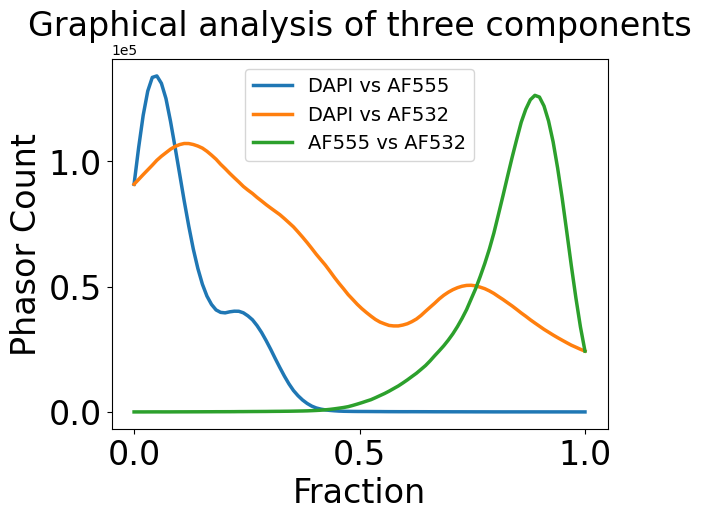

In [115]:
#counts[0] is DAPI  vs  AF555
#counts[1] is DAPI  vs  AF532
#counts[2] is AF555 vs  AF532

lw = 2.5
legendsize = 14
ticksize = 24
rad = 0.01
fractions = np.linspace(0.0, 1.0, 100)

counts = phasor_component_graphical(
    real_th,
    imag_th,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

fig, ax = plt.subplots()

ax.plot(fractions, counts[0], '-', label='DAPI vs AF555', linewidth = lw)
ax.plot(fractions, counts[1], '-', label='DAPI vs AF532', linewidth = lw)
ax.plot(fractions, counts[2], '-', label='AF555 vs AF532', linewidth = lw)
ax.set_title('Graphical analysis of three components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = fontsize)
ax.set_ylabel('Phasor Count', fontsize = fontsize)
ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.legend(fontsize = legendsize)
plt.show()

## Sharpen the image with MSSR

progress: 100%|██████████| 7/7 [00:00<00:00, 16.94it/s]


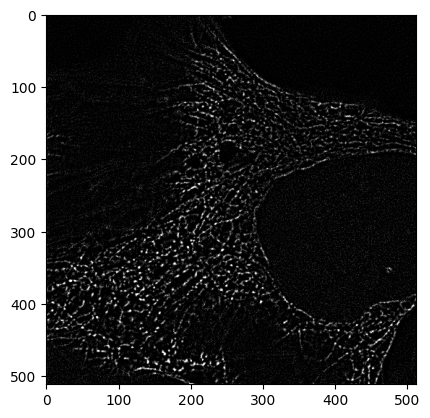

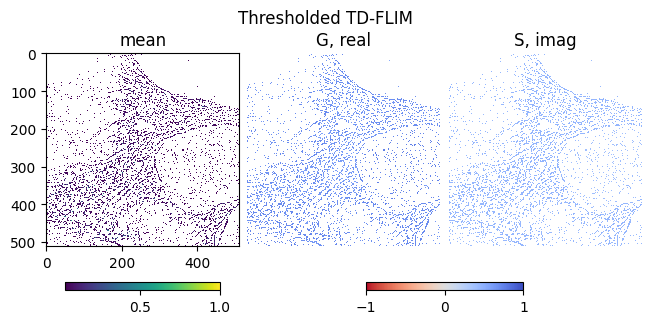

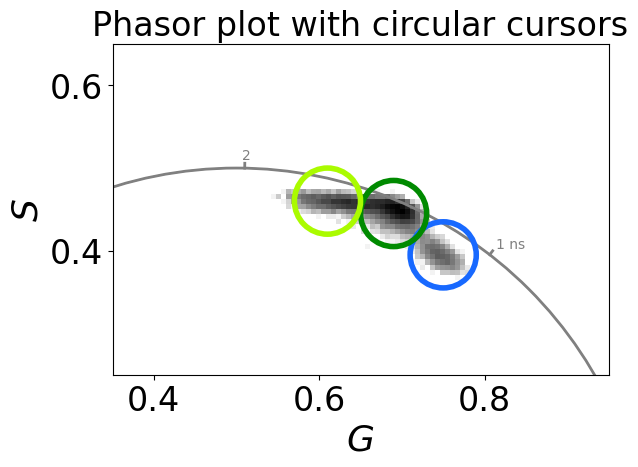

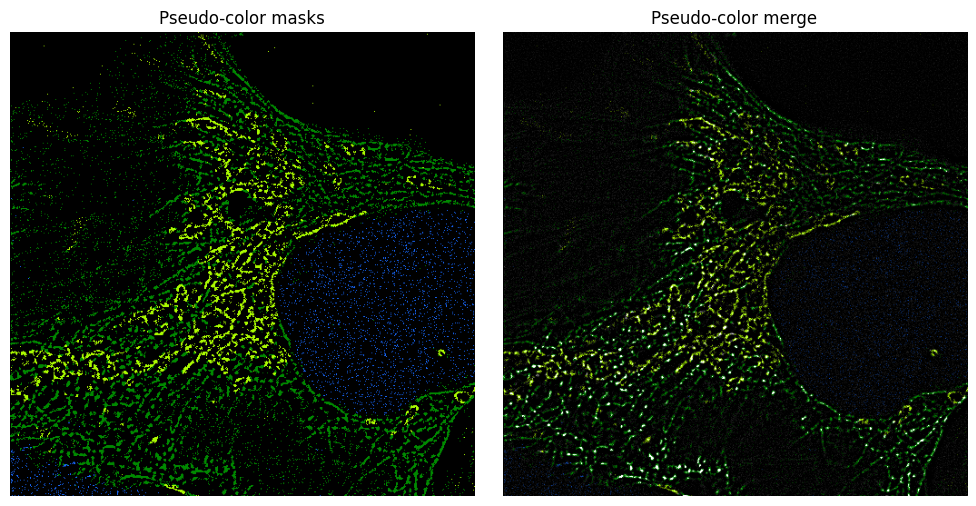

In [117]:
# Parameter for MSSR

sigma_px = 2.43
fwhm = 2.35 * sigma_px  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

#Parameters for scale bar (Change according to the size of the image analyzed)

#scalebar_width = 55.5  # in pixels
#scalebar_height = 8
# Position: bottom left with a 10-pixel margin
#x_pos = 530
#y_pos = 470
#bar_color = 'white'  # or 'black' depending on your image

#Apply MSSR1
mean_mssr1 = mssr_instance.sfMSSR(mean, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
plt.imshow(mean_mssr1, cmap='gray', vmin=0, vmax=0.25)

## Threshold
mean_th_mssr1, real_th_mssr1, imag_th_mssr1 = phasor_threshold(mean_mssr1, real_mf, imag_mf, mean_min=0.03)

#Circular cursor masking
circular_mask = mask_from_circular_cursor(
    real_th_mssr1, imag_th_mssr1, cursors_real, cursors_imag, radius=radius  #the cursor coordinates are defined above
)

#Plotting
lw = 4
plot_phasor_image(mean_th_mssr1, real_th_mssr1, imag_th_mssr1, title='Thresholded TD-FLIM')

plot = PhasorPlot(
    xlim=(0.35, 0.95), ylim=(0.25, 0.65), allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=78.02, linewidth= 2)
plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap='Greys', bins = 100)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_mssr1, colors=CATEGORICAL[1:], vmin=0, vmax=0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

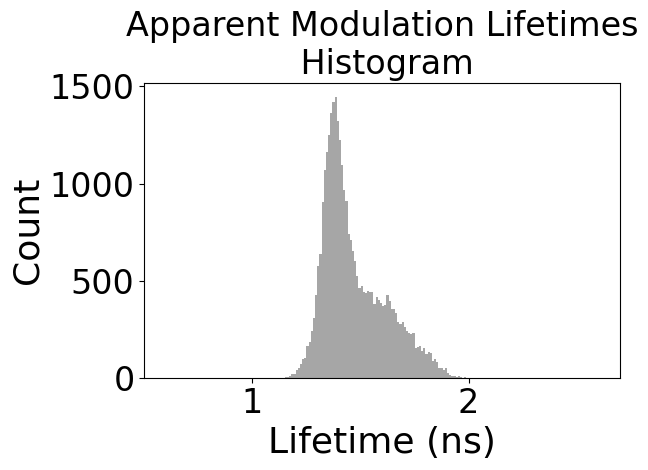

In [118]:
#### Histograms

phase_lt_mssr, mod_lt_mssr = phasor_to_apparent_lifetime(
    real_th_mssr1, imag_th_mssr1, frequency
)

plot_histograms(
    mod_lt_mssr,
    range=(0.6, 2.6),
    bins=200,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize,
    )

## Component Analysis

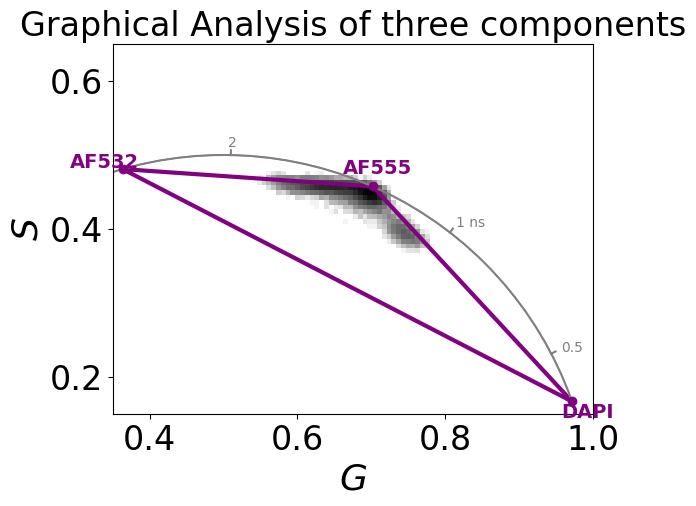

In [119]:
#                     [DAPI, AF555, AF532]
component_lifetimes = [0.35,  1.33, 2.7]
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes
)

plot = PhasorPlot(
    xlim=(0.35, 1.0), ylim=(0.15, 0.65), allquadrants=False)
plot.semicircle(frequency=frequency, linewidth= 1.5)

plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap='Greys', bins = 100)
#plot.contour(real_th, imag_th, bins=100, cmap='summer_r', norm='log')
plot.components(
    component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style
)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Graphical Analysis of three components', fontsize = fontsize)
plot.show()

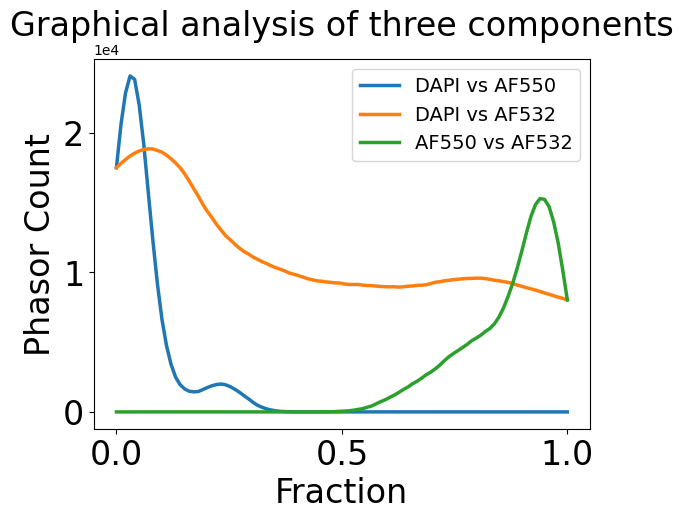

In [121]:
lw = 2.5
legendsize = 14
ticksize = 24
rad = 0.01
fractions = np.linspace(0.0, 1.0, 100)

counts = phasor_component_graphical(
    real_th_mssr1,
    imag_th_mssr1,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

fig, ax = plt.subplots()

ax.plot(fractions, counts[0], '-', label='DAPI vs AF550', linewidth = lw)
ax.plot(fractions, counts[1], '-', label='DAPI vs AF532', linewidth = lw)
ax.plot(fractions, counts[2], '-', label='AF550 vs AF532', linewidth = lw)
ax.set_title('Graphical analysis of three components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = fontsize)
ax.set_ylabel('Phasor Count', fontsize = fontsize)
ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.legend(fontsize = legendsize)
plt.show()

## Save the intensity image as TIFF

In [27]:
from google.colab import files

image = mean_th

# Save the intensity image as a TIFF file
output_image_path = "/content/drive/MyDrive/2025/MSSR-FLIM/Data/3CGQ_Intensity_image.tif"
tifffile.imwrite(output_image_path, image)

# Provide a download link for the saved image
files.download(output_image_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## nth Harmonic transformation

In [28]:
def phasor_harmonic_transform(g_matrix, s_matrix, harmonic=1):
    """
    Transform phasor (g,s) values from fundamental frequency
    to another harmonic.

    Parameters
    ----------
    g_matrix : np.ndarray
        Matrix of real (G) phasor values at fundamental frequency.
    s_matrix : np.ndarray
        Matrix of imaginary (S) phasor values at fundamental frequency.
    harmonic : int, optional
        Harmonic number to transform to (default=1, i.e., no change).

    Returns
    -------
    g_harmonic : np.ndarray
        Transformed real (G) values at chosen harmonic.
    s_harmonic : np.ndarray
        Transformed imaginary (S) values at chosen harmonic.
    """

    # Build complex phasor
    z = g_matrix + 1j * s_matrix

    # Raise to chosen harmonic
    z_harmonic = np.power(z, harmonic)

    # Separate into real and imaginary parts
    g_harmonic = np.real(z_harmonic)
    s_harmonic = np.imag(z_harmonic)

    return g_harmonic, s_harmonic

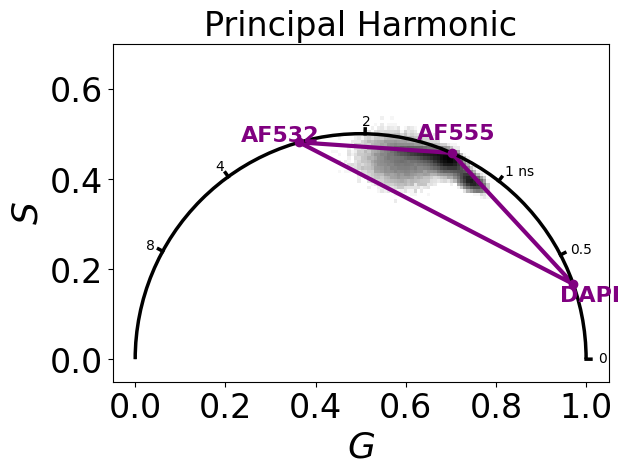

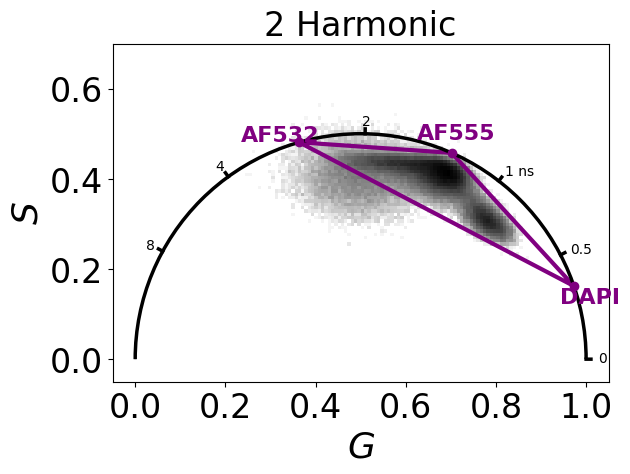

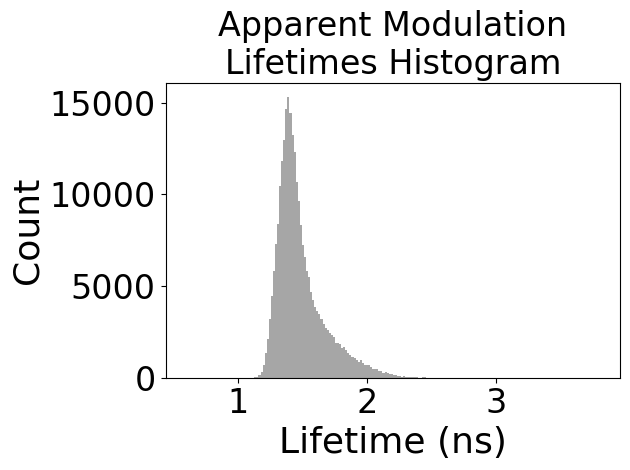

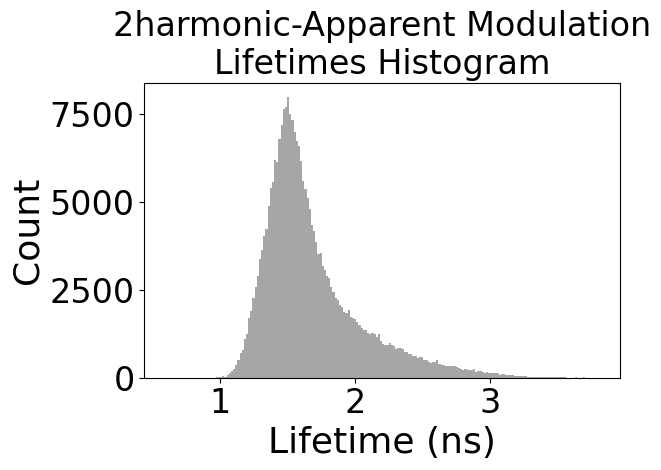

In [68]:
# Calculate the phasor components at the n-th harmonic
n = 2 # number of harmonic
real_th_2, imag_th_2 = phasor_harmonic_transform(real_th, imag_th, harmonic=n)

# Calibration of the 2nd harmonic

n_freq = frequency*n

# Calibrate phasor coordinates using reference
reference_lifetime = 4.1

settings = {
    'samples': 256,  # number of samples to synthesize
    'mean': 10,  # average intensity
    'background': 1,  # no signal from background
    'zero_phase': 0.6,  # location of IRF peak in the phase, where the decimal should increase when increasing the n
    'zero_stdev': np.pi/9,  # standard deviation of IRF in radians
}

reference_signal, _, _ = lifetime_to_signal(n_freq, reference_lifetime, **settings)

x_dim = real_th.shape[0]
y_dim = real_th.shape[1]
t_dim = settings['samples'] # Set t_dim to match the number of samples

# Create an image stack with the reference signal
img_reference_signal = np.zeros((t_dim, x_dim, y_dim))
# Assuming the signal should be the same for all pixels in the reference image
for i in range(x_dim):
  for j in range(y_dim):
    img_reference_signal[:, i, j] = reference_signal

# Calibration
reference_mean, reference_real, reference_imag = phasor_from_signal(
    img_reference_signal, axis=0
)

n_real, n_imag = phasor_calibrate(
    real_th_2,
    imag_th_2,
    reference_mean,
    reference_real,
    reference_imag,
    frequency=n_freq,
    lifetime=reference_lifetime,
)

#3 component analysis

import math

from phasorpy.component import (
    phasor_component_fit,
    phasor_component_fraction,
    phasor_component_graphical,
)

np.random.seed(42)
component_style = {
    'linestyle': '-',
    'linewidth': 3,
    'marker': 'o',
    'color': 'purple',
    'fontsize': 16,
}

#3 component analysis
#component_lifetimes = [0.35,  1.33, 2.7]
component_lifetimes_nharm = [0.17, 0.665, 1.35] #In order [DAPI, AF555, AF532]
component_real_n, component_imag_n = phasor_from_lifetime(
    n_freq, component_lifetimes_nharm
)

# Plotting the principal harmonic phasor

plot = PhasorPlot(allquadrants=False, title='Principal Harmonic')
plot.hist2d(real_th, imag_th, cmap='Greys', bins = 150)
plot.semicircle(frequency, linewidth= 2.5, color = 'k')
plot.components(
    component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style
)
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Principal Harmonic', fontsize = fontsize)

# Plotting the nth- harmonic phasor

plot = PhasorPlot(allquadrants=False, title=f'{n} Harmonic')
plot.hist2d(n_real, n_imag, cmap='Greys', bins = 150)
plot.semicircle(frequency, linewidth= 2.5, color = 'k')
plot.components(
    component_real_n, component_imag_n, labels=['DAPI', 'AF555', 'AF532'], **component_style
)
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title(f'{n} Harmonic', fontsize = fontsize)

#### Histograms

n_phase_lifetime, n_modulation_lifetime = phasor_to_apparent_lifetime(
    n_real, n_imag, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 3.8),
    bins=200,
    alpha=0.7,
    title='Apparent Modulation\nLifetimes Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

plot_histograms(
    n_modulation_lifetime,
    range=(0.6, 3.8),
    bins=200,
    alpha=0.7,
    title=f'{n}harmonic-Apparent Modulation\nLifetimes Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize,
    )

plt.show()